# Notebook Description

This notebook is concerned with producing maps of the rainfall trends in the MJO phases (1-8) and the MJO subphases (enhanced, suppressed ect.).
<br>
This is done in the following order:
<ol>
    <li> AWAP and RMM data is loaded in. </li>
    <li> Data from start of year is moved to previous year, making resampling work for individual years.</li>
    <li> Data is split into different MJO phases (1-8). </li>
    <li> Indices (count and sum) are calculated for data. </li>
    <li> Phases are then compbined together to subphases.</li>
    <li> Trends then calculated for subphases.</li>
    
</ol>

# Packages

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec

In [3]:
import sys
from importlib import reload
sys.path.append('')

# This is for loading in all the data sets that have been used in this study.
import load_dataset as load

# For splitting all of the data sets into the different phases.
import phase_calc_functions as phase_calc

# Collection of functions for plotting MJO phases.
import phase_plot_functions as phase_plot
from miscellaneous import apply_masks

In [4]:
image_dir = '../images/mjo_and_rainfall_trend_images/'

# Data

In [5]:
# Loading awap
awap = load.load_awap()

# Loading RMM
rmm = load.load_rmm()

# Making sure the two are the same length
awap = awap.where(awap.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(awap.time.values), drop = True)
len(awap.time.values), len(rmm.time.values)

(6962, 6962)

In [6]:
awap

<xarray.Dataset>
Dimensions:  (lat: 53, lon: 172, time: 6962)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -10.5 -10.25 -10.0
  * time     (time) datetime64[ns] 1974-10-01 1974-10-02 ... 2020-03-31
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 154.0 154.2 154.5 154.8
Data variables:
    precip   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    History:      AGCD Regrid on the 11th of June 2021 from /g/data/rr5 by ab...

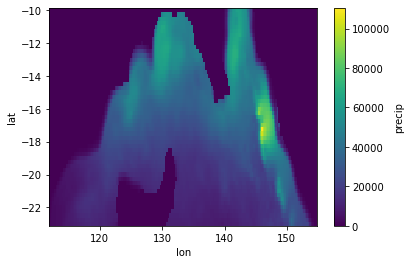

In [7]:
awap.sum(dim = 'time').precip.plot()

In [8]:
awap = apply_masks(awap)

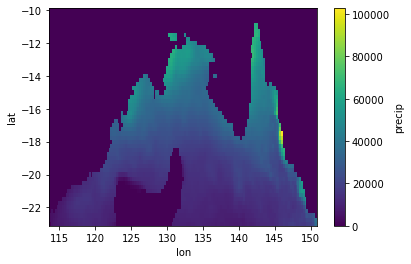

In [9]:
awap.sum(dim = 'time').precip.plot()

In [10]:
len(np.unique(awap.time.dt.year.values))

47

In [11]:
len(np.unique(rmm.time.dt.year.values))

47

In [12]:
np.unique(rmm.time.dt.year.values)

array([1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020])

In [13]:
np.unique(awap.time.dt.year.values)

array([1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020])

In [14]:
awap

<xarray.Dataset>
Dimensions:  (lat: 52, lon: 149, time: 6962)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * time     (time) datetime64[ns] 1974-10-01 1974-10-02 ... 2020-03-31
Data variables:
    precip   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    History:      AGCD Regrid on the 11th of June 2021 from /g/data/rr5 by ab...

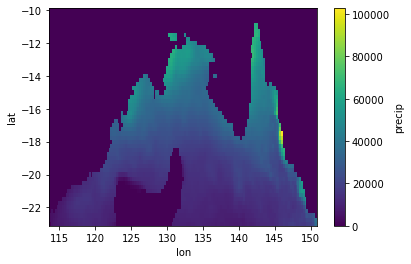

In [15]:
awap.sum(dim = 'time').precip.plot()

In [16]:
rmm

<xarray.Dataset>
Dimensions:    (time: 6962)
Coordinates:
  * time       (time) datetime64[ns] 1974-10-01 1974-10-02 ... 2020-03-31
Data variables:
    RMM1       (time) float64 0.5789 0.7589 0.8966 0.6736 ... 1.938 1.949 1.585
    RMM2       (time) float64 -0.9097 -0.9504 -0.5804 ... -0.7391 -0.4871
    phase      (time) float64 3.0 3.0 4.0 4.0 4.0 5.0 ... 4.0 4.0 4.0 4.0 4.0
    amplitude  (time) float64 1.078 1.216 1.068 0.7765 ... 2.073 2.085 1.659

# Phase Splitting and Wet Season Calibration

Splitting into different MJO phases (1-8) and then moving the data from Jan-March back one year. The moving of the data back one year means that all of the data for an individual wet season is now with in the one year. This makes resampling much easier.

In [17]:
# Readjusting the years, so when a resample takes plact, it is just the data for one wet season. If 
# this was not done it would be the end half of one wet season and the start of another. This moves that data
# from the start of the wet season back or forwards a year (I don't remember), so that they line up

phase_calc = reload(phase_calc)
awap_ws = phase_calc.wet_season_year(awap)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

KeyboardInterrupt: 

In [ ]:
awap_ws

In [ ]:
awap_split_ws

## Extreme Filter

If extreme != 0, then this will make the data set only contain rainfall that is greater than the qth percentile.

In [ ]:
extreme = 0
q = 95

In [ ]:
# Below the file gets overrided into an extreme file, this is for emergencies
awap_split_ws_origonal = awap_split_ws.copy(deep = True)

In [ ]:
awap_split_ws = awap_split_ws_origonal

In [ ]:
# The same functions below apply for extreme rainfall. Just changing the rainfall to only extremes here.
# THe ex-piece adds on to the tile, so they don't get saved as the same name

if extreme:

    threshold = awap_split_ws.reduce(np.nanpercentile, dim = 'time', q = q)
    awap_split_ws = awap_split_ws.where(awap_split_ws.precip >= threshold.precip)
    ex_piece = f'{q}th_percentile'
else:
    ex_piece = ''

In [ ]:
# Removign the points outside of a range that is too big
def max_filter(data, vmax):
    data = data.where(data.trend < vmax, vmax - 0.01)
    data = data.where(data.trend > -vmax, -vmax + 0.01)
    
    from miscellaneous import apply_masks
    data = apply_masks(data)
    
    return data

In [ ]:
# Removign the points outside of a range that is too big
def min_filter(data, vmin):
    data = data.where(data.trend > vmin, vmin + 0.01)
    
    from miscellaneous import apply_masks
    data = apply_masks(data)
    
    return data

# Count

## Resampling

Counting the number of days in each year in each phase

In [ ]:
# Resampling: getting the number of raindays each year (each year is a wet season).
awap_count = awap_split_ws.resample(time = 'y').count(dim = 'time')

# The index needs to be changed to just the year. Other wise it will be the full date.
awap_count['time'] = awap_count.time.dt.year
awap_count = awap_count.rename({'time':'year'})

For convecting the trend to subphases. They can be summed across the relevant phases.

In [ ]:
awap_count_sub = phase_calc.resample_phase_to_subphase(awap_count)

In [ ]:
awap_count_sub 

## Linear Trends

In [ ]:
awap_count_sub

In [ ]:
awap_count_sub.precip

In [ ]:
list(awap_count_sub.coords)

In [ ]:
# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_count_sub, trend_sig_count_sub, trend_percent_count_sub, trend_percent_sig_count_sub = \
    phase_calc.return_alltrendinfo_custom(awap_count_sub.precip)

In [ ]:
trend_count_sub

In [ ]:
trend_count_sub.lon.values

In [ ]:
np.unique(np.diff(trend_count_sub.lon.values), return_counts = True)

In [ ]:
trend_count_sub.lat.values

In [ ]:
np.unique(np.diff(trend_count_sub.lat.values), return_counts = True)

In [ ]:
trend_count_sub.sel(phase = 'enhanced').trend.plot()

In [ ]:
# Trend that is normalised by the number of days in each phase

phase_calc = reload(phase_calc)
trend_count_sub_norm, trend_sig_count_sub_norm, trend_percent_count_sub_norm, trend_percent_sig_count_sub_norm = \
    phase_calc.return_alltrendinfo_custom(awap_count_sub.precip, normalise = 'subphase')

In [ ]:
trend_count_sub_norm

## Plots

In [ ]:
import map_trend_functions as mapTrend

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

In [ ]:
vmax = 20
step = 4

In [ ]:
# Making sure that it is on either side of the bounds, this trend is too big. THis is need or else the color bar
# may create the arrow extreneder which will add white to the colorbar and make it unbalanaced.
trend_percent_count_sub = max_filter(trend_percent_count_sub, vmax)

In [ ]:
trend_percent_count_sub.sel(phase = 'enhanced').trend

In [ ]:
# mapTrend = reload(mapTrend)
# mapTrend.trend_plot_single_phase(trend_percent_count_sub.sel(phase = 'enhanced').trend,
#                      stip_data = trend_percent_sig_count_sub.sel(phase = 'enhanced').trend,
#                vmax = vmax, step = step, sig_size = 4.5, cmap = 'BrBG',
#                title = 'count_all_unnorm_subphase'+ ex_piece, colorbar_title = 'Percent Per Decade'
# #                ,savedir = image_dir
#                )

In [ ]:
d = trend_percent_sig_count_sub.sel(phase = 'enhanced')
d.where(np.isfinite(d.trend), 1000).trend.plot()

In [ ]:
trend_percent_sig_count_sub.trend.sel(phase = 'enhanced').plot()

In [ ]:
mapTrend = reload(mapTrend)
mapTrend.trend_plots(trend_percent_count_sub.trend, stip_data = trend_percent_sig_count_sub.trend,
               vmax = vmax, step = step, sig_size = 5.5, cmap = 'BrBG',
               title = 'count_all_unnorm_subphase'+ ex_piece, colorbar_title = 'Percent Per Decade'
#                ,savedir = image_dir
               )

In [ ]:
# Making sure that it is on either side of the bounds, this trend is too big. THis is need or else the color bar
# may create the arrow extreneder which will add white to the colorbar and make it unbalanaced.
trend_percent_count_sub_norm = max_filter(trend_percent_count_sub_norm, vmax)

In [ ]:
trend_percent_count_sub_norm.phase.values

In [ ]:
mapTrend = reload(mapTrend)
mapTrend.trend_plots(trend_percent_count_sub_norm.trend, stip_data = trend_percent_sig_count_sub_norm.trend,
               vmax = vmax, step = step, sig_size = 4.5, cmap = 'BrBG',
               title = 'count_sub_all_norm_subphase'+ ex_piece, colorbar_title = 'Percent Per Decade'
#                ,savedir = image_dir
            )

# Sum

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Phases  </font></center></div>

In [ ]:
def awap_resample_sum(awap):
    awap_resampled = awap.resample(time = 'y').sum(dim = 'time')
    awap_resampled['time'] = awap_resampled.time.dt.year
    awap_resampled = awap_resampled.rename({'time':'year'})
    
    return awap_resampled

In [ ]:
awap_sum = awap_resample_sum(awap_split_ws_origonal)

In [ ]:
awap_sum

In [ ]:
awap_sum_sub = phase_calc.resample_phase_to_subphase(awap_sum)

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

In [ ]:
phase_calc = reload(phase_calc)
trend_sum_sub, trend_sig_sum_sub, trend_percent_sum_sub, trend_percent_sig_sum_sub = \
    phase_calc.return_alltrendinfo_custom(awap_sum_sub.precip)

In [ ]:
phase_calc = reload(phase_calc)
trend_sum_sub_norm, trend_sig_sum_sub_norm, trend_percent_sum_sub_norm, trend_percent_sig_sum_sub_norm = \
    phase_calc.return_alltrendinfo_custom(awap_sum_sub.precip, normalise = 'subphase')

## Plots

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

In [ ]:
vmax = 25
step = 5

In [ ]:
# Making sure that it is on either side of the bounds, this trend is too big. THis is need or else the color bar
# may create the arrow extreneder which will add white to the colorbar and make it unbalanaced.
trend_percent_sum_sub = max_filter(trend_percent_sum_sub, vmax)

In [ ]:
mapTrend = reload(mapTrend)
mapTrend.trend_plots(trend_percent_sum_sub.trend, stip_data = trend_percent_sig_sum_sub.trend,
                vmax = vmax, step = step, sig_size = 4.5, cmap = 'BrBG',
               title = 'sum_all_unnorm_sub'+ ex_piece, colorbar_title = 'Percent Per Decade',
#                savedir = savedir
               )

In [ ]:
# Making sure that it is on either side of the bounds, this trend is too big. THis is need or else the color bar
# may create the arrow extreneder which will add white to the colorbar and make it unbalanaced.
trend_percent_sum_sub_norm = max_filter(trend_percent_sum_sub_norm, vmax)

In [ ]:
mapTrend = reload(mapTrend)
mapTrend.trend_plots(trend_percent_sum_sub_norm.trend, stip_data = trend_percent_sig_sum_sub_norm.trend,
               vmax = vmax, step = step, sig_size = 4.5, cmap = 'BrBG',
               title = 'sum_all_norm_sub'+ ex_piece, colorbar_title = 'Percent Per Decade',
#                savedir = savedir
               )

# Combined Plot - Count and Sum

GRL only allows a max of four figures. Thus I am combining the plots together

In [ ]:
# Mergind the data sets together so that only two data sets need to be read into the function and not
# four. These can then be itterated through using a for loop (for index in data:)


# The unormalised data.
merged_count_sum =\
        xr.merge([trend_percent_count_sub.rename({'trend':'count'}), 
                  trend_percent_sum_sub.rename({'trend':'sum'})])

stip_count_sum = xr.merge([trend_percent_sig_count_sub.rename({'trend':'count'}),
          trend_percent_sig_sum_sub.rename({'trend':'sum'})])

merged_count_sum_norm =\
        xr.merge([trend_percent_count_sub_norm .rename({'trend':'count'}), 
                  trend_percent_sum_sub_norm .rename({'trend':'sum'})])

stip_count_sum_norm  = xr.merge([trend_percent_sig_count_sub_norm .rename({'trend':'count'}),
          trend_percent_sig_sum_sub_norm .rename({'trend':'sum'})])

In [ ]:
merged_count_sum

In [ ]:
load = reload(load)

In [ ]:
mapTrend = reload(mapTrend)

mapTrend.trend_plot_combined_single_phase(merged_count_sum.sel(phase = 'enhanced'),
                             stip_data = stip_count_sum.sel(phase = 'enhanced'), vmax = 35, step = 5,
                       title = 'merged_count_sum_enhanced_BrBG', colorbar_title = 'Percent Per Decade',
                                    phase = 'enhanced', cmap = 'BrBG'
#                        ,savedir = image_dir
                       )

In [ ]:
mapTrend = reload(mapTrend)

mapTrend.trend_plot_combined_better(merged_count_sum, stip_data = stip_count_sum, vmax = 35, step = 5,
                       title = 'merged_count_sum_BrBG', colorbar_title = 'Percent Per Decade',
                       cmap = 'BrBG'
#                       ,savedir = image_dir
                       )

In [ ]:
mapTrend = reload(mapTrend)

mapTrend.trend_plot_combined_single_phase(merged_count_sum_norm.sel(phase = 'enhanced'),
                             stip_data = stip_count_sum_norm.sel(phase = 'enhanced'), vmax = 35, step = 5,
                       title = 'merged_count_sum_norm_enhanced_BrBG', colorbar_title = 'Percent Per Decade',
                                    phase = 'enhanced', cmap = 'BrBG'
#                        ,savedir = image_dir
                       )

In [ ]:
mapTrend = reload(mapTrend)
mapTrend.trend_plot_combined_better(merged_count_sum_norm , stip_data = stip_count_sum_norm , vmax = 35, step = 5,
                       title = 'merged_count_sum_norm_BRBG', colorbar_title = 'Percent Per Decade',
                        cmap = 'BrBG'
#                        ,savedir = image_dir
                       )

# Fraction  of Total Trend

This code compares the fraction of the trend in the enhanced phase to the trend overall to get an estimate of the total trend.

In [ ]:
trend_sum_sub

## Total Trend Calc

In [ ]:
phase_calc = reload(phase_calc)
awap_ws = phase_calc.wet_season_year(awap)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [ ]:
def count_resample(awap_data):
    # countring the rainfall events in each Wheeler and Hendon Phase
    awap_count = awap_data.resample(time = 'y').count(dim = 'time')
    awap_count['time'] = awap_count.time.dt.year
    awap_count = awap_count.rename({'time':'year', 'precip':'number'}) # to match the rmm count
    return awap_count

def sum_resample(awap_data):
    # sumring the rainfall events in each Wheeler and Hendon Phase
    awap_sum = awap_data.resample(time = 'y').sum(dim = 'time')
    awap_sum['time'] = awap_sum.time.dt.year
    awap_sum = awap_sum.rename({'time':'year', 'precip':'number'}) # to match the rmm sum
    return awap_sum

In [ ]:
# The number of raindays each wet season.
awap_count = count_resample(awap_ws)

# The total amount of rainfall each wet season.
awap_sum = sum_resample(awap_ws)

In [ ]:
# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_count, trend_sig_count, trend_percent_count, trend_percent_sig_count = \
    phase_calc.return_alltrendinfo_custom(awap_count.number)

# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_sum, trend_sig_sum, trend_percent_sum, trend_percent_sig_sum = \
    phase_calc.return_alltrendinfo_custom(awap_sum.number)

In [ ]:
trend_sum

## Comp Calc

In [ ]:
trend_sum

In [ ]:
trend_sum_sub

In [ ]:
trend_count_sub.sel(phase = 'enhanced').trend.plot()

In [ ]:
trend_count.trend.plot()

In [ ]:
frac_count_exp = trend_count_sub.sel(phase = 'enhanced').squeeze() * 100/trend_count
frac_sum_exp = trend_sum_sub.sel(phase = 'enhanced').squeeze() * 100/trend_sum

In [ ]:
frac_count_exp = frac_count_exp.where(np.logical_or(
                                        trend_percent_count.trend > 1,
                                        trend_percent_count.trend < -1),
                                      0)
frac_sum_exp = frac_sum_exp.where(np.logical_or(
                                        trend_percent_sum.trend > 2,
                                        trend_percent_sum.trend < -2),
                                      0)

In [ ]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
import plotting_functions as pf
pf = reload(pf)

fig, gs = pf.fig_formatter(height_ratios = [1,1], width_ratios = [1, 0.1], hspace = 0.0, wspace = 0.2)


vmax = 150
vmin = -vmax
step = 25
cmapi = 'BrBG'
# cmapi = 'Blues'


cmap, levels = pf.colorbar_creater(vmax, step, cmap = cmapi,vmin = vmin, add_white = 1,extender = 1)

ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_no_controurf_NWASquare(
                            max_filter(frac_count_exp, vmax)['trend'], 
                            ax, cmap, levels, square = 1)
ax.set_title('Number of Raindays', size = 15);
ax.annotate('a)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


cax = plt.subplot(gs[:,1])
ticks = np.core.defchararray.add(levels.astype(str)  , np.tile('%',len(levels)))
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks,
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)



ax = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_no_controurf_NWASquare(
    max_filter(frac_sum_exp, vmax)['trend'], 
                            ax, cmap, levels, square = 1)

ax.set_title('Rainfall', size = 15);
ax.annotate('b)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


# fig.savefig('../images/mjo_and_rainfall_trend_images/percent_contribution_BrBG.png', dpi = 600
#            ,bbox_inches = 'tight', pad = 0)

# PDF's

In [ ]:
def plot_hist(ax,data, phase, xmax = 700, step = 1, title = '', xlabel = ''):
    
    
    green = '#44a198'
    brown = '#c38e3f'#'#dbb973'
    # Subsetting data.
    dist1 = data.isel(year = slice(0,21)).sel(
        phase = phase,lon = slice(110, 135), lat = slice(-25,-10)).precip.values.flatten()
    dist2 = data.isel(year = slice(22,43)).sel(
        phase = phase,lon = slice(110, 135), lat = slice(-25,-10)).precip.values.flatten()
    # Bins
    bins = np.arange(5,xmax,step)
    # First data slice
    hist_dat1 = ax.hist(dist1, bins = bins, color = brown,
            alpha = 0.7, zorder = 0, label = '1975 to 1995'
    #         , density = True
            );
    # Second data slice
    hist_dat2 = ax.hist(dist2, bins = bins, 
             color = green,alpha = 0.6,zorder = 1, label = '1996 to 2016'
    #         , density = True
            );
    # Xlims
    ax.set_xlim(5,xmax)
    # Legend
    leg = ax.legend(fontsize = 12)
    #Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Labels
    ax.set_ylabel('Frequency', size = 10);
    ax.set_xlabel(xlabel, size = 10);
    ax.set_title(title, size = 15);
    
    return hist_dat1, hist_dat2

In [ ]:
fig = plt.figure(figsize = (10,6))
gs = gridspec.GridSpec(2,1, hspace = 0.4)
phase = 'enhanced'

ax1 = fig.add_subplot(gs[0])
sum_dat1, sum_dat2 = plot_hist(ax1,awap_sum_sub, phase, xmax = 800, step = 10,
          title = 'Rainfall (mm)', xlabel = 'Rainfall (mm)')

ax2 = fig.add_subplot(gs[1])
count_dat1, count_dat2 = plot_hist(ax2,awap_count_sub, phase,xmax = 70, step = 1,
          title = 'Number of Raindays', xlabel = 'Number of Raindays')

fig.suptitle('{} Phase'.format(phase.capitalize()), fontsize = 15);
# fig.savefig('../images/mjo_and_rainfall_trend_images/rainfall_enhanced_phase_pdf_BrBG.png', dpi = 600)

In [ ]:
mapTrend = reload(mapTrend)

mapTrend.trend_plot_combined_single_phase(merged_count_sum.sel(phase = 'enhanced'),
                             stip_data = stip_count_sum.sel(phase = 'enhanced'), vmax = 35, step = 5,
                       title = 'merged_count_sum_enhanced_BrBG', colorbar_title = 'Percent Per Decade',
                                    phase = 'enhanced', cmap = 'BrBG'
#                        ,savedir = image_dir
                       )

In [ ]:
merged_count_sum.sel(phase = 'enhanced').count

In [ ]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
mapTrend = reload(mapTrend)

fig, gs = pf.fig_formatter(height_ratios = [1,1,.7,.7], width_ratios = [1, .1], 
                           hspace = 0.4, wspace = 0.2)


vmax = 35
vmin = -vmax
step = 5
cmapi = 'BrBG'

cmap, levels = pf.colorbar_creater(vmax, step, cmap = cmapi,vmin = vmin, add_white = 1,extender = 1)

ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())

# ax, data, cmap, levels, stip_data = None
plot = mapTrend.trend_plot_single(ax,
                            merged_count_sum.sel(phase = 'enhanced')['count'],
                          cmap, levels, stip_data = stip_count_sum.sel(phase = 'enhanced')['count'])
ax.set_title('Number of Raindays', size = 15);
ax.annotate('a)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


cax = plt.subplot(gs[:2,1])
ticks = np.core.defchararray.add(levels.astype(str)  , np.tile('%',len(levels)))
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks,
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)


###### Second Plot
ax = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
plot = mapTrend.trend_plot_single(ax,
                merged_count_sum.sel(phase = 'enhanced')['sum'],
              cmap, levels, stip_data = stip_count_sum.sel(phase = 'enhanced')['sum'])

ax.set_title('Rainfall', size = 15);
ax.annotate('b)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)

#### Adding in PDF's


phase = 'enhanced'



ax2 = fig.add_subplot(gs[2,:])
count_dat1, count_dat2 = plot_hist(ax2,awap_count_sub, phase,xmax = 70, step = 1,
          title = 'Number of Raindays', xlabel = 'Number of Raindays')
ax2.annotate('c)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


ax1 = fig.add_subplot(gs[3,:])
sum_dat1, sum_dat2 = plot_hist(ax1,awap_sum_sub, phase, xmax = 800, step = 10,
          title = 'Rainfall (mm)', xlabel = 'Rainfall (mm)')
ax1.annotate('d)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


# fig.savefig('../images/mjo_and_rainfall_trend_images/percent_trend_and_pdf.png', dpi = 600
#            ,bbox_inches = 'tight', pad = 0)

In [ ]:
def plot_hist(ax,data, phase, xmax = 700, step = 1, title = '', xlabel = ''):
    
    
    green = '#44a198'
    brown = '#c38e3f'#'#dbb973'
    # Subsetting data.
    dist1 = data.isel(year = slice(0,21)).sel(
        phase = phase,lon = slice(110, 135), lat = slice(-25,-10)).precip.values.flatten()
    dist2 = data.isel(year = slice(22,43)).sel(
        phase = phase,lon = slice(110, 135), lat = slice(-25,-10)).precip.values.flatten()
    # Bins
    bins = np.arange(5,xmax,step)
    # First data slice
    hist_dat1 = ax.hist(dist1, bins = bins, color = brown,
            alpha = 0.7, zorder = 0, label = '1975 to 1995'
    #         , density = True
            );
    # Second data slice
    hist_dat2 = ax.hist(dist2, bins = bins, 
             color = green,alpha = 0.6,zorder = 1, label = '1996 to 2016'
    #         , density = True
            );
    # Xlims
    ax.set_xlim(5,xmax)
    # Legend
    leg = ax.legend(fontsize = 12, loc='center left', bbox_to_anchor=(1.06, 0.5))
    #Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Labels
    ax.set_ylabel('Frequency', size = 10);
    ax.set_xlabel(xlabel, size = 10);
    ax.set_title(title, size = 15);
    
    return hist_dat1, hist_dat2

In [ ]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
mapTrend = reload(mapTrend)
pf = reload(pf)
fig, gs = pf.fig_formatter(height_ratios = [1,.55,1,.55], width_ratios = [1, .1], 
                           hspace = 0.2, wspace = 0.2)


vmax = 35
vmin = -vmax
step = 5
cmapi = 'BrBG'

cmap, levels = pf.colorbar_creater(vmax, step, cmap = cmapi,vmin = vmin, add_white = 1,extender = 1)

ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())

# ax, data, cmap, levels, stip_data = None
plot = mapTrend.trend_plot_single(ax,
                            merged_count_sum.sel(phase = 'enhanced')['count'],
                          cmap, levels, stip_data = stip_count_sum.sel(phase = 'enhanced')['count'])
ax.set_title('Number of Raindays', size = 15);
ax.annotate('a)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


cax = plt.subplot(gs[0,1])
ticks = np.core.defchararray.add(levels.astype(str)  , np.tile('%',len(levels)))
# ticks[::2] = ''
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks[::2],
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)


###### Second Plot
ax = fig.add_subplot(gs[2,0], projection = ccrs.PlateCarree())
plot = mapTrend.trend_plot_single(ax,
                merged_count_sum.sel(phase = 'enhanced')['sum'],
              cmap, levels, stip_data = stip_count_sum.sel(phase = 'enhanced')['sum'])

ax.set_title('Rainfall', size = 15);
ax.annotate('c)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


cax = plt.subplot(gs[2,1])
ticks = np.core.defchararray.add(levels.astype(str)  , np.tile('%',len(levels)))
# ticks[::2] = ''
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks[::2],
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)


#### Adding in PDF's


phase = 'enhanced'

ax2 = fig.add_subplot(gs[1,0])
count_dat1, count_dat2 = plot_hist(ax2,awap_count_sub, phase,xmax = 70, step = 1,
          title = '', xlabel = 'Number of Raindays')
ax2.annotate('b)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


ax1 = fig.add_subplot(gs[3,0])
sum_dat1, sum_dat2 = plot_hist(ax1,awap_sum_sub, phase, xmax = 800, step = 10,
          title = '', xlabel = 'Rainfall (mm)')
ax1.annotate('d)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15);

# fig.savefig('../images/mjo_and_rainfall_trend_images/percent_trend_and_pdf_ordered.png', dpi = 600
#            ,bbox_inches = 'tight', pad = 0)

In [ ]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
mapTrend = reload(mapTrend)

fig, gs = pf.fig_formatter(height_ratios = [1,1,.7,.7], width_ratios = [1, .1], 
                           hspace = 0.4, wspace = 0.2)


vmax = 35
vmin = -vmax
step = 5
cmapi = 'BrBG'

cmap, levels = pf.colorbar_creater(vmax, step, cmap = cmapi,vmin = vmin, add_white = 1,extender = 1)

ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())

# ax, data, cmap, levels, stip_data = None
plot = mapTrend.trend_plot_single(ax,
                            merged_count_sum_norm.sel(phase = 'enhanced')['count'],
                          cmap, levels, stip_data = stip_count_sum_norm.sel(phase = 'enhanced')['count'])
ax.set_title('Number of Raindays/Number of Days', size = 15);
ax.annotate('a)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


cax = plt.subplot(gs[:2,1])
ticks = np.core.defchararray.add(levels.astype(str)  , np.tile('%',len(levels)))
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks[::2],
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)


###### Second Plot
ax = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
plot = mapTrend.trend_plot_single(ax,
                merged_count_sum_norm.sel(phase = 'enhanced')['sum'],
              cmap, levels, stip_data = stip_count_sum_norm.sel(phase = 'enhanced')['sum'])

ax.set_title('Rainfall/Day', size = 15);
ax.annotate('b)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15);

# fig.savefig('../images/mjo_and_rainfall_trend_images/percent_trend_norm_less_ticks.png', dpi = 600
#            ,bbox_inches = 'tight', pad = 0)